# Arrival_Understanding
.
.
.


In [1]:
import sys
sys.path.append('../')

from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

import os
from PIL import Image
import requests
import copy
import torch
import numpy as np

/auto/home/nareknurijanyan/miniforge3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/auto/home/nareknurijanyan/miniforge3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
pretrained = "lmms-lab/llava-next-interleave-qwen-7b"
model_name = "llava_qwen"
device = torch.device("cuda:0")
device_map = {"": device}
llava_model_args = {
    "multimodal": True,
}
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, **llava_model_args)

model.to(device)
model.eval()

Loaded LLaVA model: lmms-lab/llava-next-interleave-qwen-7b


/auto/home/nareknurijanyan/miniforge3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Overwriting config with {'image_aspect_ratio': 'pad'}
Loading vision tower: google/siglip-so400m-patch14-384


Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Model Class: LlavaQwenForCausalLM


LlavaQwenForCausalLM(
  (model): LlavaQwenModel(
    (embed_tokens): Embedding(151646, 4096)
    (layers): ModuleList(
      (0-31): 32 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=True)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
    (vis

In [4]:
def files_count(path):
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    return num_files

In [5]:
def return_prediction(question):
    conv_template = "qwen_1_5"
    conv = copy.deepcopy(conv_templates[conv_template])
    conv.append_message(conv.roles[0], question)
    conv.append_message(conv.roles[1], None)
    prompt_question = conv.get_prompt()
    input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
    image_sizes = [image.size for image in images]
    cont = model.generate(
        input_ids,
        images=image_tensors,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0,
        max_new_tokens=4096,
    )
    text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
    print(text_outputs[0])
    return(text_outputs[0])

In [9]:
path_to_directory = "/nfs/np/mnt/big/tigrann/AirVLN_Data/val_seen_448x448/3IKDQS3DRMYCD4YN3FXL7EVVUSTCIO"
count = files_count(path_to_directory)
images = []
actions = []
instruction = "lower yourself to street level turn right until facing the road then head straight. at the next corner turn 180 degrees and head straight on the road. at the second intersection turn right onto the bridge and head straight. at the end of the road turn right. at the next intersection turn right. at the mural of the dog on the right turn left 90 degrees and head straight across the water. once on the road again turn right and stop at the first red building on the left."
description = "You are navigating a flying drone based on visual input and instructions. Analyze the current and previous images to determine whether the current frame that you see is the final destination or not. If the current frame is the final one you should return 1 otherwise the answer should be 0. Use the instruction and the differences between the images to guide your choice. The question is the following. Is this the final location?"

for i in range(count):
    path = f"{path_to_directory}/{i}.png"
 #   path =  path_to_directory + "/" + str(i) + ".png"
    image_current = Image.open(path)
    images.append(image_current)
    if i + 1 >= 10:
        images_10 = images[-10:]
        image_tensors = process_images(images_10, image_processor, model.config)
        image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
        image_tokens = "{DEFAULT_IMAGE_TOKEN}" * 9
        
        question = f"""
        [Description] {description} [/Description]
        [INSTR] {instruction} [/INSTR]
        [ACTIONS] {actions} [/ACTIONS]
        [PreviousScenes] {image_tokens} [PreviousScenes]
        [CurrentScene] {DEFAULT_IMAGE_TOKEN} [/CurrentScene]
        
        [Choice]
        0) NOT_ARRIVED
        1) ARRIVED
        [/Choice]
        """ 
        actions.append(return_prediction(question))
        
    else:
        images_initial = images[-(i + 1):]
        image_tensors = process_images(images_initial, image_processor, model.config)
        image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
        image_tokens = "{DEFAULT_IMAGE_TOKEN}" * i

        question = f"""
        [Description] {description} [/Description]
        [INSTR] {instruction} [/INSTR]
        [ACTIONS] {actions} [/ACTIONS]
        [PreviousScenes] {image_tokens} [PreviousScenes]
        [CurrentScene] {DEFAULT_IMAGE_TOKEN} [/CurrentScene]
        
        [Choice]
        0) NOT FINAL
        1) FINAL
        """
        actions.append(return_prediction(question))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [8]:
print(actions)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


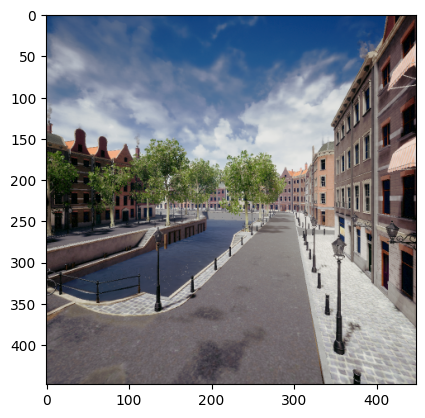

In [10]:
import matplotlib.pyplot as plt

path = f"{path_to_directory}/{16}.png"
image_current = Image.open(path)
images.append(image_current)

plt.imshow(image_current)

In [56]:
def accuracy(paths, ground_truth, n=5):
    C = [0] * n
    for episode_id, path in paths.items():
        gt = ground_truth[episode_id][:n]
        for i in range(n):
            if int(path[i]) == gt[i]:
                C[i] += 1
    return [c / len(paths) for c in C]

In [57]:
paths = "~/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_07.json"
ground_truth = "~/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_07.json"

In [1]:
import json
import numpy as np

def accuracy_mean(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    return np.mean(C)

def accuracy_mean_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return np.mean(C)

def accuracy_mean_15_end(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[15:]
    return np.mean(C)

def accuracy_mean_0_143(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:143]
    return np.mean(C)


def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_07.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_07.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])


# Calculate accuracy for each step
n_steps = max  # Modify as necessary to handle paths with up to 150 steps
accuracy_mean = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15 = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143 = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

print("Eval_with_07")
print("\n")
# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results = []
results.append(f"Eval_with_07")
results.append(f"Accuracy_Mean = {accuracy_mean}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143}")
results.append(f"_")
results


Eval_with_07




['Eval_with_07',
 'Accuracy_Mean = 0.36228241605745787',
 'Accuracy_Mean_0_15 = 0.46428571428571436',
 'Accuracy_Mean_15_END = 0.35387555081886535',
 'Accuracy_Mean_0_143 = 0.33037374466523584',
 '_']

In [2]:
import json

def accuracy_mean(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k] + 1):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    return np.mean(C)

def accuracy_mean_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k] + 1):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return np.mean(C)

def accuracy_mean_15_end(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k] + 1):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[15:]
    return np.mean(C)

def accuracy_mean_0_143(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k] + 1):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:143]
    return np.mean(C)


# Load the paths (predictions) and ground truth from JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_18.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_18.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])

# # Calculate accuracy for each step
# n_steps = max  # Modify as necessary to handle paths with up to 150 steps
# accuracy_per_step = accuracy(paths, ground_truth, n=n_steps)


# print("Eval_with_18")
# print("\n")
# # Print the accuracy per step
# for i, acc in enumerate(accuracy_per_step):
#     print(f"Step {i+1}: Accuracy = {acc:.4f}")


accuracy_mean = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15 = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143 = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results.append(f"Eval_with_18")
results.append(f"Accuracy_Mean = {accuracy_mean}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143}")
results.append(f"_")
results

['Eval_with_07',
 'Accuracy_Mean = 0.36228241605745787',
 'Accuracy_Mean_0_15 = 0.46428571428571436',
 'Accuracy_Mean_15_END = 0.35387555081886535',
 'Accuracy_Mean_0_143 = 0.33037374466523584',
 '_',
 'Eval_with_18',
 'Accuracy_Mean = 0.11778666143482185',
 'Accuracy_Mean_0_15 = 0.27619047619047615',
 'Accuracy_Mean_15_END = 0.10473140197693824',
 'Accuracy_Mean_0_143 = 0.10099347930598',
 '_']

In [3]:
max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])

print(max)


197


In [4]:
len(paths.items())

56

In [5]:
ground_truth

{'39OWYR0EPTP8S0UVO2ERQR5AHEQFYA': [2,
  2,
  2,
  2,
  4,
  2,
  1,
  1,
  5,
  5,
  1,
  5,
  5,
  5,
  1,
  5,
  5,
  3,
  3,
  5,
  1,
  5,
  5,
  5,
  5,
  5,
  1,
  5,
  5,
  5,
  5,
  5,
  5,
  1,
  5,
  2,
  2,
  2,
  2,
  2,
  2,
  5,
  2,
  1,
  1,
  4,
  1,
  4,
  1,
  1,
  1,
  3,
  3,
  2,
  2,
  2,
  4,
  1,
  3,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  4,
  4,
  1,
  4,
  4,
  4,
  4,
  4,
  1,
  4,
  4,
  1,
  4,
  0],
 '31Z0PCVWUTDZWLGVWDTGUI0ES46T7W': [4,
  4,
  4,
  4,
  3,
  3,
  3,
  1,
  4,
  1,
  1,
  1,
  1,
  7,
  1,
  1,
  1,
  1,
  1,
  1,
  7,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  5,
  1,
  2,
  1,
  5,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  5,
  2,
  2,
  2,
  4,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  6,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  5,
  1,
  1,
  1,
  5,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  5,
  5,
  5,
  0],
 '3AMW0RGHOM0Q7EFBV31LL5L7BZXNPD': [4,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  3,
 

In [6]:
import json

translate = {"A" : 0,
             "B" : 1,
             "C" : 2,
             "D" : 3,
             "E" : 4,
             "F" : 5,
             "G" : 6,
             "H" : 7 
             }

# Load the paths (predictions) and ground truth from JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_ah.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_ah.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)

# Calculate accuracy for each step

In [7]:
translate["A"]

0

In [8]:
print(paths)

{'39OWYR0EPTP8S0UVO2ERQR5AHEQFYA': ['E', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'], '31Z0PCVWUTDZWLGVWDTGUI0ES46T7W': ['E', 'E', 'D', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'B', 'B', 'B', 'C', 'D', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'B', 'D', 'D', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'B'], '3AMW0RGHOM0Q7EFBV31LL5L7BZXNPD': ['D', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D

In [9]:
ground_truth

{'39OWYR0EPTP8S0UVO2ERQR5AHEQFYA': [2,
  2,
  2,
  2,
  4,
  2,
  1,
  1,
  5,
  5,
  1,
  5,
  5,
  5,
  1,
  5,
  5,
  3,
  3,
  5,
  1,
  5,
  5,
  5,
  5,
  5,
  1,
  5,
  5,
  5,
  5,
  5,
  5,
  1,
  5,
  2,
  2,
  2,
  2,
  2,
  2,
  5,
  2,
  1,
  1,
  4,
  1,
  4,
  1,
  1,
  1,
  3,
  3,
  2,
  2,
  2,
  4,
  1,
  3,
  1,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  4,
  4,
  1,
  4,
  4,
  4,
  4,
  4,
  1,
  4,
  4,
  1,
  4,
  0],
 '31Z0PCVWUTDZWLGVWDTGUI0ES46T7W': [4,
  4,
  4,
  4,
  3,
  3,
  3,
  1,
  4,
  1,
  1,
  1,
  1,
  7,
  1,
  1,
  1,
  1,
  1,
  1,
  7,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  5,
  1,
  2,
  1,
  5,
  1,
  2,
  1,
  2,
  1,
  2,
  1,
  5,
  2,
  2,
  2,
  4,
  1,
  1,
  4,
  1,
  1,
  1,
  1,
  6,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  5,
  1,
  1,
  1,
  5,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  4,
  1,
  5,
  5,
  5,
  0],
 '3AMW0RGHOM0Q7EFBV31LL5L7BZXNPD': [4,
  4,
  4,
  4,
  4,
  4,
  4,
  3,
  3,
 

In [10]:
# def accuracy(paths, ground_truth, n=5):
#     # Initialize a list to store correct counts per step
#     C = [0] * n
#     for episode_id, path in paths.items():
#         gt = ground_truth[episode_id][:n]
#         # Compare predictions with ground truth for each step
#         for i in range(n):
#             if len(path[i]) > 1:
#                 if translate[path[i][0]] == gt[i]:
#                     C[i] += 1
#             elif translate[path[i]] == gt[i]:
#                 C[i] += 1
#     return [c / len(paths) for c in C]

def accuracy_mean(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if translate[path[k][0]] == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    return np.mean(C)

def accuracy_mean_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if translate[path[k][0]] == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return np.mean(C)

def accuracy_mean_15_end(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if translate[path[k][0]] == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[15:]
    return np.mean(C)

def accuracy_mean_0_143(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if translate[path[k][0]] == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:143]
    return np.mean(C)



paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_ah.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_ah.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])

# Calculate accuracy for each step
n_steps = max  # Modify as necessary to handle paths with up to 150 steps
#accuracy_per_step = accuracy(paths, ground_truth, n=n_steps)


In [11]:
# print("Eval_with_AH")
# print("\n")
# # Print the accuracy per step
# for i, acc in enumerate(accuracy_per_step):
#     print(f"Step {i+1}: Accuracy = {acc:.4f}")

In [12]:
accuracy_mean = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15 = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143 = accuracy_mean_0_143(paths, ground_truth, n=n_steps)


results.append(f"Eval_with_AH")
results.append(f"Accuracy_Mean = {accuracy_mean}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143}")
results.append(f"_")

In [13]:
results

['Eval_with_07',
 'Accuracy_Mean = 0.36228241605745787',
 'Accuracy_Mean_0_15 = 0.46428571428571436',
 'Accuracy_Mean_15_END = 0.35387555081886535',
 'Accuracy_Mean_0_143 = 0.33037374466523584',
 '_',
 'Eval_with_18',
 'Accuracy_Mean = 0.11778666143482185',
 'Accuracy_Mean_0_15 = 0.27619047619047615',
 'Accuracy_Mean_15_END = 0.10473140197693824',
 'Accuracy_Mean_0_143 = 0.10099347930598',
 '_',
 'Eval_with_AH',
 'Accuracy_Mean = 0.3445331473601761',
 'Accuracy_Mean_0_15 = 0.48214285714285704',
 'Accuracy_Mean_15_END = 0.3331916877627024',
 'Accuracy_Mean_0_143 = 0.3112499602494335',
 '_']

In [1]:
import json
import numpy as np

def micro_average(paths, ground_truth, n=5):
    C = [0] * n
    total = 0

    for _, path in paths.items():
            total += len(path)

    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    return sum(C) / total

def accuracy_mean(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    return np.mean(C)

def accuracy_mean_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return np.mean(C)

def accuracy_mean_15_end(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[15:]
    return np.mean(C)

def accuracy_mean_0_143(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:143]
    return np.mean(C)


def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_last_15.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_last_15.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])


n_steps = max
micro_average_ = micro_average(paths, ground_truth, n=n_steps)
accuracy_mean_ = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15_ = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end_ = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143_ = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

print("Eval_with_07")
print("\n")
# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results = []
results.append(f"Eval_with_last_15")
results.append(f"Micro_Average = {micro_average_}")
results.append(f"Accuracy_Mean = {accuracy_mean_}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15_}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end_}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143_}")
results.append(f"_")
results


Eval_with_07




['Eval_with_last_15',
 'Micro_Average = 0.40226082161566035',
 'Accuracy_Mean = 0.38611681376335916',
 'Accuracy_Mean_0_15 = 0.4160642570281124',
 'Accuracy_Mean_15_END = 0.38438907665193106',
 'Accuracy_Mean_0_143 = 0.3967442977308213',
 '_']

In [2]:
def accuracy_path_level(paths, ground_truth):
    list_result = []
    for episode_id, path in paths.items():
        gt = ground_truth[episode_id]
        count = 0
        for k in range(len(path)):
            if int(path[k]) == (gt[k]):
                    count += 1
        list_result.append(count / len(path))
    return list_result

np.mean(accuracy_path_level(paths, ground_truth))

0.3949150223099533

In [3]:

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_uniform_15.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_uniform_15.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)

max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])


n_steps = max
micro_average_ = micro_average(paths, ground_truth, n=n_steps)
accuracy_mean_ = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15_ = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end_ = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143_ = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

print("Eval_with_07")
print("\n")
# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results.append(f"Eval_with_uniform")
results.append(f"Micro_Average = {micro_average_}")
results.append(f"Accuracy_Mean = {accuracy_mean_}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15_}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end_}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143_}")
results.append(f"_")
results


Eval_with_07




['Eval_with_last_15',
 'Micro_Average = 0.40226082161566035',
 'Accuracy_Mean = 0.38611681376335916',
 'Accuracy_Mean_0_15 = 0.4160642570281124',
 'Accuracy_Mean_15_END = 0.38438907665193106',
 'Accuracy_Mean_0_143 = 0.3967442977308213',
 '_',
 'Eval_with_uniform',
 'Micro_Average = 0.4014949606347456',
 'Accuracy_Mean = 0.3819062421720819',
 'Accuracy_Mean_0_15 = 0.41465863453815266',
 'Accuracy_Mean_15_END = 0.3800166810740393',
 'Accuracy_Mean_0_143 = 0.39509662799693523',
 '_']

In [4]:
np.mean(accuracy_path_level(paths, ground_truth))

0.3947935756170417

In [5]:

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_exp_15.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_exp_15.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)

max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])


n_steps = max
micro_average_ = micro_average(paths, ground_truth, n=n_steps)
accuracy_mean_ = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15_ = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end_ = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143_ = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

print("Eval_with_07")
print("\n")
# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results.append(f"Eval_with_exp")
results.append(f"Micro_Average = {micro_average_}")
results.append(f"Accuracy_Mean = {accuracy_mean_}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15_}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end_}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143_}")
results.append(f"_")
results


Eval_with_07




['Eval_with_last_15',
 'Micro_Average = 0.40226082161566035',
 'Accuracy_Mean = 0.38611681376335916',
 'Accuracy_Mean_0_15 = 0.4160642570281124',
 'Accuracy_Mean_15_END = 0.38438907665193106',
 'Accuracy_Mean_0_143 = 0.3967442977308213',
 '_',
 'Eval_with_uniform',
 'Micro_Average = 0.4014949606347456',
 'Accuracy_Mean = 0.3819062421720819',
 'Accuracy_Mean_0_15 = 0.41465863453815266',
 'Accuracy_Mean_15_END = 0.3800166810740393',
 'Accuracy_Mean_0_143 = 0.39509662799693523',
 '_',
 'Eval_with_exp',
 'Micro_Average = 0.39944245320589405',
 'Accuracy_Mean = 0.3781536482106399',
 'Accuracy_Mean_0_15 = 0.43012048192771085',
 'Accuracy_Mean_15_END = 0.3751555616500396',
 'Accuracy_Mean_0_143 = 0.39259650289557413',
 '_']

In [6]:
np.mean(accuracy_path_level(paths, ground_truth))

0.39365233938685945

In [ ]:
import json



def accuracy(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k] + 1):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    return C

# Load the paths (predictions) and ground truth from JSON files
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_18.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_18.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])

# Calculate accuracy for each step
n_steps = max  # Modify as necessary to handle paths with up to 150 steps
accuracy_per_step = accuracy(paths, ground_truth, n=n_steps)


print("Eval_with_18")
print("\n")
# Print the accuracy per step
for i, acc in enumerate(accuracy_per_step):
    print(f"Step {i+1}: Accuracy = {acc:.4f}")


In [1]:
translate = {"A" : 0,
             "B" : 1,
             "C" : 2,
             "D" : 3,
             "E" : 4,
             "F" : 5,
             "G" : 6,
             "H" : 7 
             }

"AO" in translate.keys()


In [12]:
translate["C"]

2

In [1]:
acceped_patterns = ["0", "1", "2", "3", "4", "5", "6", "7"]


In [17]:
"1" in acceped_patterns

True

In [13]:
acceped_patterns[1:8:5]

['1', '6']

In [16]:
46//15

3

In [1]:
l = [i for i in range(100)]

In [79]:
i = 76
l[i - 14 * (i // 15) : i + 1 : i // 15]

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76]

In [5]:
def generate_exponential_sequence(start, length, rate):
    sequence = [start]
    for _ in range(1, length):
        next_value = sequence[-1] * rate
        sequence.append(next_value)
    return sequence

# Example usage
start_value = 1  # starting value of the sequence
sequence_length = 10  # number of elements in the sequence
increase_rate = 1.2  # rate of increase (e.g., 2 means the next value is 2x the previous one)

sequence = generate_exponential_sequence(start_value, sequence_length, increase_rate)
print(sequence)


[1, 1.2, 1.44, 1.728, 2.0736, 2.48832, 2.9859839999999997, 3.5831807999999996, 4.299816959999999, 5.159780351999999]


In [6]:
def generate_exponential_sequence_in_range(lower_bound, upper_bound, rate):
    sequence = []
    value = lower_bound

    while value <= upper_bound:
        sequence.append(value)
        value *= rate
    
    return sequence

# Example usage
lower_bound = 1  # lower bound of the sequence
upper_bound = 100  # upper bound of the sequence
increase_rate = 2  # rate of increase (e.g., 2 means the next value is 2x the previous one)

sequence = generate_exponential_sequence_in_range(lower_bound, upper_bound, increase_rate)
print(sequence)


[1, 2, 4, 8, 16, 32, 64]


In [149]:
import numpy as np

def exp_sequence(upper_bound):
    def generate_exponential_sequence_with_count(lower_bound, upper_bound, num_values):
        rate = (upper_bound / lower_bound) ** (1 / (num_values - 1))
        sequence = [int(round(upper_bound + 1 - lower_bound * (rate ** i), 0)) for i in range(num_values)]
        return sequence
    lower_bound = 1      
    num_values = 15
    sequence = generate_exponential_sequence_with_count(lower_bound, upper_bound, num_values)
    sequence  = list(set(sequence))
    current = upper_bound
    while len(sequence) < num_values:
        if current in sequence:
            current -= 1
        else:
            sequence.append(current)
    sequence.sort()
    return sequence

up_b = 200
nums = [i for i in range(up_b)]
indices = exp_sequence(up_b)
selected_elements = [nums[i - 1] for i in indices]


In [147]:
print(exp_sequence(up_b))

[1, 64, 107, 137, 157, 171, 180, 187, 191, 194, 196, 197, 198, 199, 200]


In [150]:
selected_elements

[0, 63, 106, 136, 156, 170, 179, 186, 190, 193, 195, 196, 197, 198, 199]

In [ ]:
import json
import numpy as np

def micro_average(paths, ground_truth, n=5):
    C = [0] * n
    total = 0

    for _, path in paths.items():
            total += len(path)

    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    return sum(C) / total

def accuracy_mean(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    return np.mean(C)

def accuracy_mean_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return np.mean(C)

def accuracy_mean_15_end(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[15:]
    return np.mean(C)

def accuracy_mean_0_143(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:143]
    return np.mean(C)


def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_results_last_15.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/notebooks/val_seen_gt_last_15.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)


max = 0

for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])


n_steps = max
micro_average_ = micro_average(paths, ground_truth, n=n_steps)
accuracy_mean_ = accuracy_mean(paths, ground_truth, n=n_steps)
accuracy_mean_0_15_ = accuracy_mean_0_15(paths, ground_truth, n=n_steps)
accuracy_mean_15_end_ = accuracy_mean_15_end(paths, ground_truth, n=n_steps)
accuracy_mean_0_143_ = accuracy_mean_0_143(paths, ground_truth, n=n_steps)

print("Eval_with_07")
print("\n")
# Print the accuracy per step
#for i, acc in enumerate(accuracy_per_step):
#    print(f"Step {i+1}: Accuracy = {acc:.4f}")

results = []
results.append(f"Eval_with_last_15")
results.append(f"Micro_Average = {micro_average_}")
results.append(f"Accuracy_Mean = {accuracy_mean_}")
results.append(f"Accuracy_Mean_0_15 = {accuracy_mean_0_15_}")
results.append(f"Accuracy_Mean_15_END = {accuracy_mean_15_end_}")
results.append(f"Accuracy_Mean_0_143 = {accuracy_mean_0_143_}")
results.append(f"_")
results


In [20]:
import json
import numpy as np
from tqdm import tqdm

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def accuracy_0_15(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(path[k]) == (gt[k]):
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return C

def accuracy_only_up(paths, ground_truth, n=5):
    C = [0] * n
    for k in range(n):
        for episode_id, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                if int(gt[k]) == 4:
                    C[k] += 1
    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return C

def accuracy_popular_move(paths, populars, n=5):
    C = [0] * n
    
    for k in range(n):
        for _, path in paths.items():
            if len(path) < k + 1:
                pass
            else:
                if int(path[k]) == int(populars[k]):
                    C[k] += 1

    # print(C)

    for j in range(n):
        count = 0
        for _ , path in paths.items():
            if len(path) >= j + 1:
                count += 1
        C[j] = C[j] / count
    C = np.array(C)
    C = C[:15]
    return C

In [21]:
train_file = "/nfs/np/mnt/big/tigrann/AirVLN_Data/data/aerialvln-s/train.json"
with open(train_file, 'r') as f:
    data = json.load(f)['episodes']

paths, gt_paths = {}, {}
for episode in tqdm(data):
    instruction, trajectory_id = episode['instruction']['instruction_text'], episode['trajectory_id']
    scene_id = episode['scene_id']
    # if not os.path.isdir(f'{folder}/{trajectory_id}'):
    #     continue
    actions = episode['actions']
    gt_paths[episode['episode_id']] = actions
    
def popular_steps(ground_truth, n=5):
    C = [0] * n
    
    for k in range(n):
        populars = [0] * 8
        for episode_id, path in ground_truth.items():
            if len(path) < k + 1:
                pass
            else:
                gt = ground_truth[episode_id]
                populars[int(gt[k])] += 1
        pop_move = np.argmax(populars)
        C[k] = pop_move
    return(C)

max = 0
for path in gt_paths.items():
    if max < len(path[1]):
        max = len(path[1])

n_steps = max
pop_move = popular_steps(gt_paths, n=n_steps)

100%|██████████| 10113/10113 [00:00<00:00, 1149200.66it/s]


In [22]:
paths_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_last_15_results.json"
gt_file = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_last_15_gt.json"

paths = load_json(paths_file)
ground_truth = load_json(gt_file)

max = 0
for path in paths.items():
    if max < len(path[1]):
        max = len(path[1])

n_steps = max
accuracy_0_15_ = accuracy_0_15(paths, ground_truth, n=n_steps)
accuracy_only_up_ = accuracy_only_up(paths, ground_truth, n=n_steps)
accuracy_popular_move_ = accuracy_popular_move(ground_truth, pop_move, n=n_steps)
accuracy_popular_move_

array([0.68975904, 0.52108434, 0.40963855, 0.27409639, 0.32831325,
       0.31927711, 0.29518072, 0.30722892, 0.34638554, 0.44578313,
       0.45783133, 0.49698795, 0.46987952, 0.46084337, 0.49698795])

In [23]:
paths_uniform = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_uniform_15_results.json"
gt_uniform = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_uniform_15_gt.json" 
paths_exp = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_exp_15_results.json"
gt_exp = "/auto/home/nareknurijanyan/LLaVA-NeXT-AirVLN/evals/outputs/val_seen_exp_15_gt.json" 

paths_uniform = load_json(paths_uniform)
gt_uniform = load_json(gt_uniform)
paths_exp = load_json(paths_exp)
gt_exp = load_json(gt_exp)

In [24]:
accuracy_unif_15_ = accuracy_0_15(paths_uniform, gt_uniform, n=n_steps)
accuracy_only_up_u_ = accuracy_only_up(paths_uniform, gt_uniform, n=n_steps)
accuracy_exp_15_ = accuracy_0_15(paths_exp, gt_exp, n=n_steps)
accuracy_only_up_e_ = accuracy_only_up(paths_exp, gt_exp, n=n_steps)

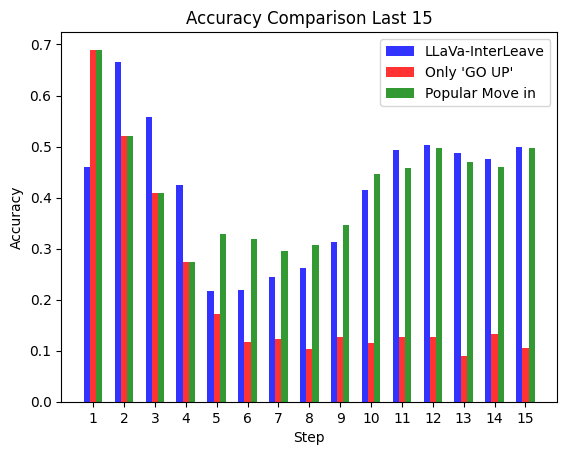

In [32]:
import matplotlib.pyplot as plt
steps = range(1, 16)
fig, ax = plt.subplots()
opacity = 0.8
bar_width = 0.2

rects1 = ax.bar(steps, accuracy_0_15_, bar_width,
                alpha=opacity, color='b',
                label='LLaVa-InterLeave')

rects2 = ax.bar([x + bar_width for x in steps], accuracy_only_up_, bar_width,
                alpha=opacity, color='r',
                label='Only \'GO UP\'')

rects3 = ax.bar([x + 2 * bar_width for x in steps], accuracy_popular_move_, bar_width,
                alpha=opacity, color='g',
                label='Popular Move in ')

ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Last 15')
ax.set_xticks([x + bar_width for x in steps])
ax.set_xticklabels(steps)
ax.legend()

plt.savefig("accuracy_comparison_last_15_015.png", format='png', dpi=300)
plt.show()

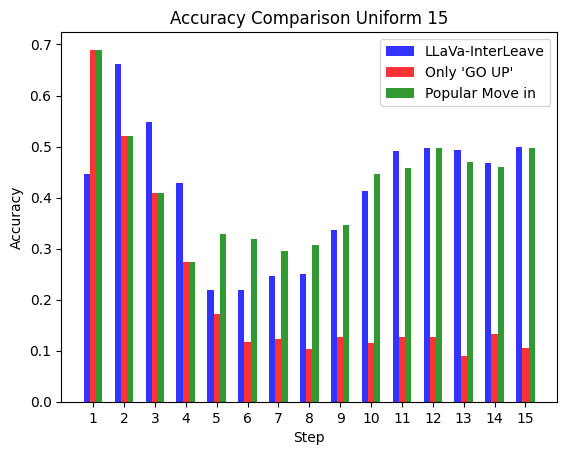

In [33]:
import matplotlib.pyplot as plt
steps = range(1, 16)
fig, ax = plt.subplots()
opacity = 0.8
bar_width = 0.2

rects1 = ax.bar(steps, accuracy_unif_15_, bar_width,
                alpha=opacity, color='b',
                label='LLaVa-InterLeave')

rects2 = ax.bar([x + bar_width for x in steps], accuracy_only_up_u_, bar_width,
                alpha=opacity, color='r',
                label='Only \'GO UP\'')

rects3 = ax.bar([x + 2 * bar_width for x in steps], accuracy_popular_move_, bar_width,
                alpha=opacity, color='g',
                label='Popular Move in ')


ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Uniform 15')
ax.set_xticks([x + bar_width for x in steps])
ax.set_xticklabels(steps)
ax.legend()

plt.savefig("accuracy_comparison_unif_15_015.png", format='png', dpi=300)
plt.show()

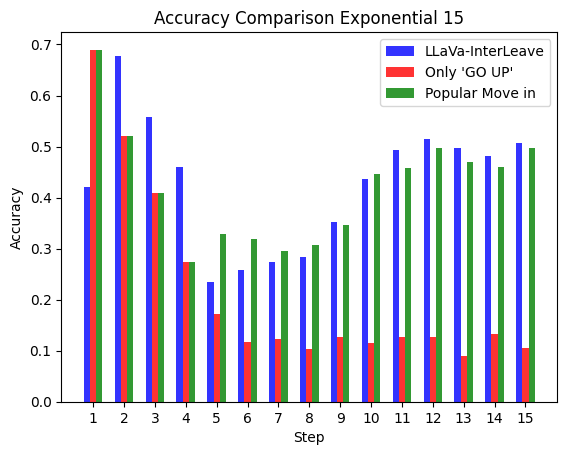

In [34]:
import matplotlib.pyplot as plt
steps = range(1, 16)
fig, ax = plt.subplots()
opacity = 0.8
bar_width = 0.2

rects1 = ax.bar(steps, accuracy_exp_15_, bar_width,
                alpha=opacity, color='b',
                label='LLaVa-InterLeave')

rects2 = ax.bar([x + bar_width for x in steps], accuracy_only_up_e_, bar_width,
                alpha=opacity, color='r',
                label='Only \'GO UP\'')

rects3 = ax.bar([x + 2 * bar_width for x in steps], accuracy_popular_move_, bar_width,
                alpha=opacity, color='g',
                label='Popular Move in ')


ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Exponential 15')
ax.set_xticks([x + bar_width for x in steps])
ax.set_xticklabels(steps)
ax.legend()

plt.savefig("accuracy_comparison_exp_15_015.png", format='png', dpi=300)
plt.show()

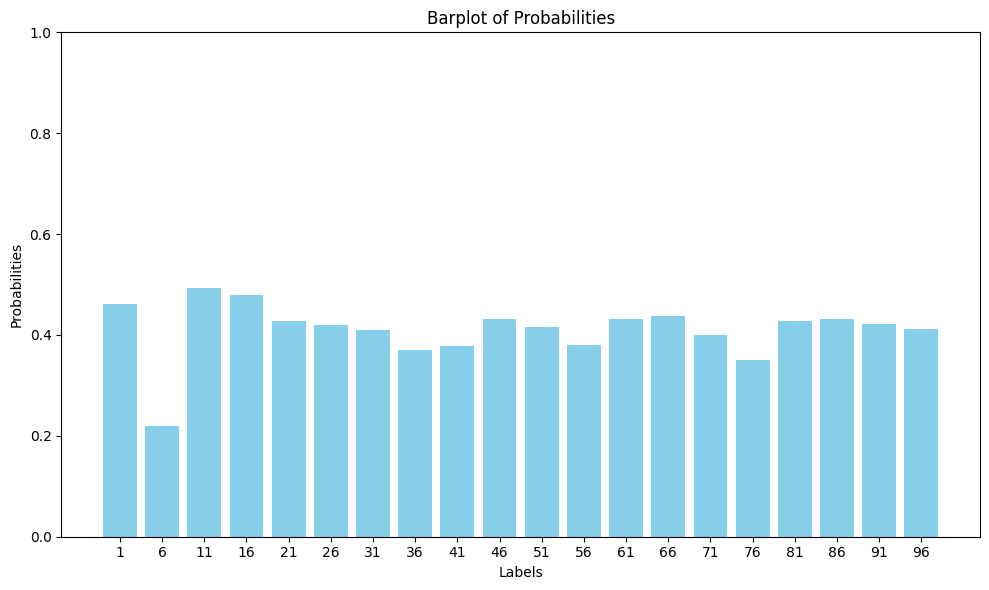

In [ ]:
import matplotlib.pyplot as plt

# Generate 20 random values representing probabilities between 0 and 1
probabilities = accuracy_0_15_

# Create labels ranging from 0 to 1 in increments of 0.05 (20 steps)
labels = [f"{i * 5 + 1}" for i in range(20)]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, probabilities, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Probabilities')
plt.title('Barplot of Probabilities')
plt.ylim(0, 1)

# Display plot
plt.tight_layout()
plt.show()
